In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from utils import *

# Data Loading & Preprocessing

In [2]:
event = "코나 화재"
communities = ['clien', 'bobae', 'fmkorea', 'naver_cafe']

In [3]:
per_community_dfs = []
for community in communities:
    posts_df = pd.read_csv(f'../data/{event}/{community}_posts.csv') 
    posts_df['from'] = community
    posts_df.created_at = posts_df.created_at.apply(parse_dates)

    comments_df = pd.read_csv(f'../data/{event}/{community}_comments.csv') 
    if community=='clien':
        comments_df.columns = ['cmt_author', 'cmt_count', 'post_id', 'cmt_created_at']
    # Currently, just use number of comments
    comments_df = comments_df.groupby(['post_id'], as_index = False).agg({
        'cmt_author': ['count'],
    })

    comments_df.columns = comments_df.columns.droplevel(0)
    comments_df.columns = ['post_id', 'cmt_count']
    per_community_df = pd.merge(posts_df, comments_df, left_on='id', right_on='post_id', how='left')
    per_community_dfs.append(per_community_df)
df = pd.concat(per_community_dfs)

In [4]:
print(df.shape)
df.isnull().sum()

(3517, 12)


id               0
title            0
content        324
likes            6
url              0
author           0
views            0
created_at      15
updated_at    3271
from             0
post_id        184
cmt_count      184
dtype: int64

In [5]:
# Preprocessing
df = df.dropna(subset=['created_at']) # 생성 시간이 없는 게시물 제거
df.views = df.views.map(str).apply(remove_commna).apply(convert_str_to_int)
df.likes = df.likes.map(str).apply(remove_commna).apply(convert_str_to_float)
df.cmt_count = df.cmt_count.fillna(0).map(int)
print(df.shape)

(3502, 12)


In [6]:
# filtering by keyword & add created_day column
keywords = list(event.split())
filtered_df = filter_by_keyword(df, keywords)
filtered_df = add_created_day_col(filtered_df).sort_values(by=['created_at'])

In [7]:
real_events = [
    ("2020-10-08", "Red", "리콜 발표"), # 특정 기간(2017년 9월 29일부터 2020년 3월 13일)동안 생산된 코나 일렉트릭 25,564대를 리콜 
    ("2020-12-18", "Red", "단종"), # 코나 단종
    ("2021-03-22", "Red", "전량 리콜"), # 코나 전량 배터리 리콜 결정
    ("2023-02-28", "Red", "2세대 공개"), # 코나 EV 2세대 디자인 필름 공개
    ("2023-04-13", "Red", "2세대 출시"), # 코나 EV 2세대 정식 출시
    ("2021-02-24", "#79db93", "화재"), # 국토부에서 배터리 결함 발표 
    ("2020-04-02", "#79db93", "화재"), # 코나 화재 (경기도 안산)
    ("2020-05-29", "#79db93", "화재"), # 코나 화재 (대구 북구 주차장)
    ("2020-08-07", "#79db93", "화재"), # 코나 화재 (대구 북구 주차장)
    ("2020-08-15", "#79db93", "화재"), # 코나 화재 (전북 정읍시 주차장)
    ("2020-09-26", "#79db93", "화재"), # 코나 화재 (제주)
    ("2020-08-07", "#79db93", "화재"), # 코나 화재 (대구 북구 주차장)
    ("2020-10-04", "#79db93", "화재"), # 코나 화재 (대구 달성군 주차장)
    ("2020-10-17", "#79db93", "화재"), # 코나 화재 (남양주)
    ("2021-01-23", "#79db93", "화재"), # 코나 화재 (대구 달서구 충전소)
    ("2021-02-16", "#79db93", "화재"), # LG 배터리 사용한 현대 전기버스 화재
    ("2021-06-23", "#79db93", "화재"), # 코나 화재 (충남 보령)
    ("2021-07-01", "#79db93", "화재"), # 코나 화재 (세종시)
    ("2022-01-11", "#79db93", "화재"), # 코나 화재 (충남 태안읍)
    ("2022-02-12", "#79db93", "화재"), # 코나 화재 (부산 지하주차장)
    ("2023-05-24", "#79db93", "화재"), # 코나 화재 (대구 달성군)
]

# 화제성 시각화

In [8]:
# Per day Post (count)
vis_df = filtered_df
day_start = '2020-08-01'
day_end = '2021-12-31'
title = "Per day Number of Posts (count)"
result_df = plot_per_day_post_counts_with_events(vis_df, title=title, day_start=day_start, day_end=day_end)

In [9]:
# Per day number of views (total)
vis_df = filtered_df
day_start = '2020-08-01'
day_end = '2021-12-31'
title = "Per day Number of Views (Total)"
result_df = plot_per_day_target_val_sum_with_events(vis_df, title=title, target_val='views', day_start=day_start, day_end=day_end)

In [10]:
# Per day number of comments (total)
vis_df = filtered_df
day_start = '2020-08-01'
day_end = '2021-12-31'
title = "Per day Number of Comments (Total)"
result_df = plot_per_day_target_val_sum_with_events(vis_df, title=title, target_val='cmt_count', day_start=day_start, day_end=day_end)

In [11]:
# Per day number of likes (total)
vis_df = filtered_df
day_start = '2020-08-01'
day_end = '2021-12-31'
title = "Per day Number of Likes (Total)"
result_df = plot_per_day_target_val_sum_with_events(vis_df, title=title, target_val='likes', day_start=day_start, day_end=day_end)

# Hot 게시물 선정 및 댓글 수 변화 추이 확인

In [12]:
hot_posts = filtered_df[filtered_df['created_day'] =='2020-10-04']
hot_posts = hot_posts.sort_values(by=['cmt_count', 'views', 'likes'], ascending=[False, False, False])
hot_posts.head(3)

,id,title,content,likes,url,author,views,created_at,updated_at,from,post_id,cmt_count,created_day
701,513046,자동차리콜센터 코나ev 결함신고 협조 요청,"안녕하세요?코나ev (일명 불나, 고장잘나) 의 문제가 도를 지나치는 것 같아 자동...",9.0,https://cafe.naver.com/ca-fe/ArticleRead.nhn?c...,닐닐I코나I대구,1066,2020-10-04 11:08:00,NaN,naver_cafe,513046.0,45,2020-10-04
688,513112,코나 내일 계약하는데ㅜ,* 관련된 주제에 대해 미리 카페내 검색해 보셨습니까? : (네/아니오) 네* 전기...,1.0,https://cafe.naver.com/ca-fe/ArticleRead.nhn?c...,또똥파파l코나l울진,1312,2020-10-04 13:15:00,NaN,naver_cafe,513112.0,41,2020-10-04
199,15445104,"코나 전기차, 대구서 완속충전 후 화재...벌써 12번째",ZD Net은 테크뉴스만 보도하는 줄 알았는데 자동차 뉴스도 보도하는군요코나 전기차...,12.0,https://www.clien.net/service/board/cm_car/154...,이정복,7770,2020-10-04 09:44:41,2020-10-04 09:47:56,clien,15445104.0,36,2020-10-04


In [13]:
# load dataset with full comments info
per_community_dfs = []
for community in communities:
    posts_df = pd.read_csv(f'../data/{event}/{community}_posts.csv') 
    posts_df['from'] = community
    posts_df.created_at = posts_df.created_at.apply(parse_dates)

    comments_df = pd.read_csv(f'../data/{event}/{community}_comments.csv') 
    comments_df.cmt_created_at = comments_df.cmt_created_at.apply(parse_dates)
    if community=='clien':
        comments_df.columns = ['cmt_author', 'cmt_count', 'post_id', 'cmt_created_at']
    per_community_df = pd.merge(posts_df, comments_df, left_on='id', right_on='post_id', how='left')
    per_community_dfs.append(per_community_df)
df = pd.concat(per_community_dfs)

In [14]:
condition = (df.id==513046) | (df.id==513112) | (df.id==15445104)
hot_post_df = df[condition]
hot_post_df['rel_time'] = hot_post_df['cmt_created_at'] - hot_post_df['created_at'] # time delta

/var/folders/w5/5pw5wgsx5vj49hnx6bdft1_80000gn/T/ipykernel_83019/1341400479.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## With Continuous Time

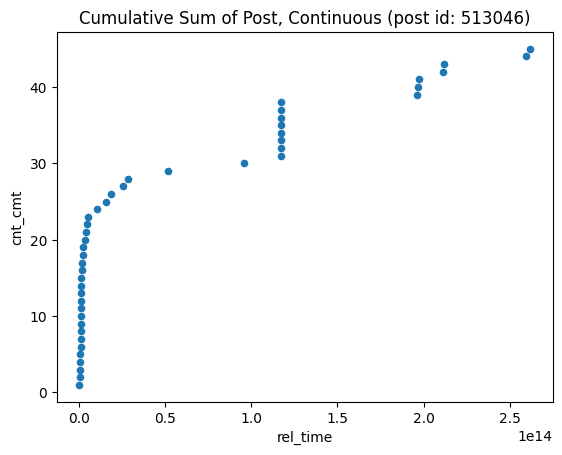

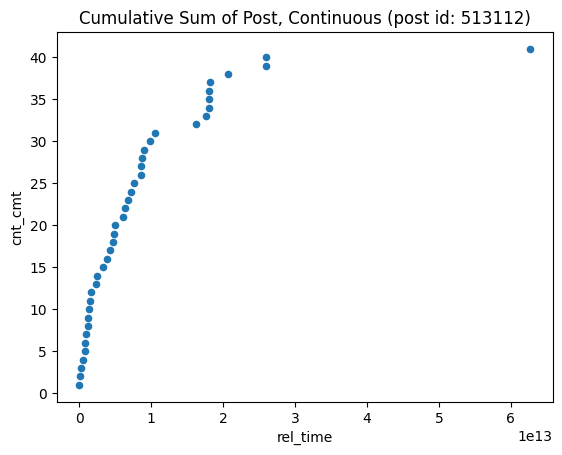

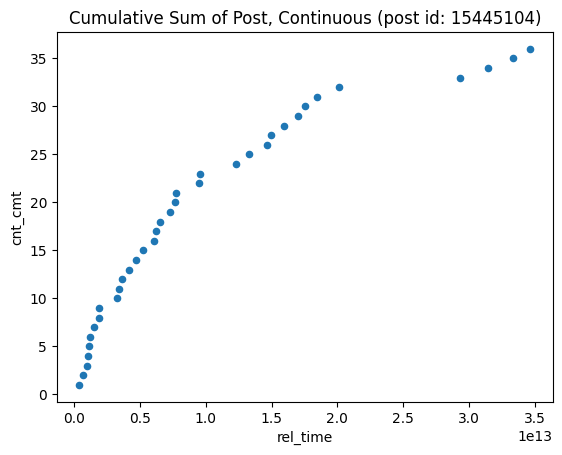

In [15]:
post_ids = [513046, 513112, 15445104]

for post_id in post_ids:
    post_df = hot_post_df[hot_post_df.id==post_id].sort_values(by=['rel_time'])
    post_df['cnt_cmt'] = [x for x in range(1, post_df.shape[0]+1)]
    post_df.plot(x='rel_time', y='cnt_cmt', kind='scatter')
    plt.title(f"Cumulative Sum of Post, Continuous (post id: {post_id})")

## With Discrete Time (Applying Binning)

/var/folders/w5/5pw5wgsx5vj49hnx6bdft1_80000gn/T/ipykernel_83019/3929829380.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



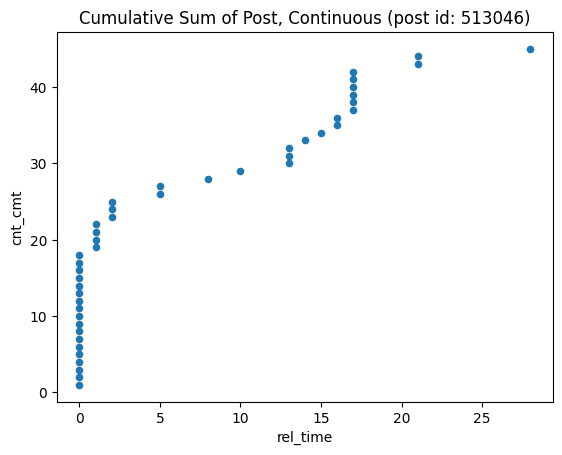

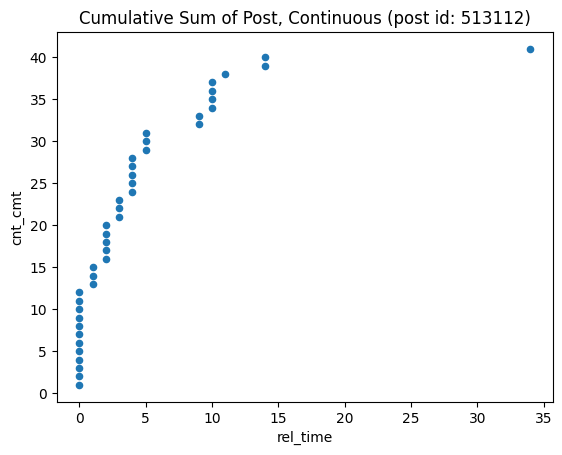

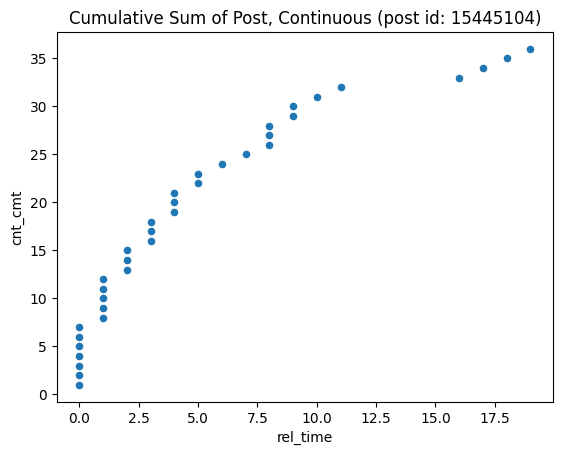

In [16]:
hot_post_df['rel_time'] = hot_post_df['rel_time'].apply(timedelta_to_seconds) // (30*60) # applying binnig (30 minutes)

post_ids = [513046, 513112, 15445104]
for post_id in post_ids:
    post_df = hot_post_df[hot_post_df.id==post_id].sort_values(by=['rel_time'])
    post_df['cnt_cmt'] = [x for x in range(1, post_df.shape[0]+1)]
    post_df.plot(x='rel_time', y='cnt_cmt', kind='scatter')
    plt.title(f"Cumulative Sum of Post, Continuous (post id: {post_id})")